In [1]:
#Building / continuing from BT.pynb: extend to MNIST and clean the file up

In [2]:
import fastai
fastai.__version__

'2.6.3'

In [3]:
import torch
from torch import nn
torch.__version__

/Users/hamishhaggerty/opt/anaconda3/envs/old_fastai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.11.0'

In [4]:
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import inspect

#These are imports

In [5]:
#Like most other SSL algorithms BT's model consists of an encoder and projector (MLP) layer.
#Definition is straightforward:
#https://colab.research.google.com/github/KeremTurgutlu/self_supervised/blob/master/nbs/14%20-%20barlow_twins.ipynb#scrollTo=1M6QcUChcvpz

class BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector):self.encoder,self.projector = encoder,projector
        
    def forward(self,x): return self.projector(self.encoder(x))
    
    
#Nothing much to this: Just a simple API for the BT model, with inputs encoder and projector. 


In [6]:
#HOWEVER instead of directly using the above, by passing both an encoder and a projector, create_barlow_twins_model
#function can be used by minimally passing a predefined encoder and the expected input channels.

#In the paper it's mentioned that MLP layer consists of 3 layers... following function will create a 3 layer
#MLP projector with batchnorm and ReLU by default. Alternatively, you can change bn and nlayers. 


#Questions: Why torch.no_grad() when doing this?
def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return BarlowTwinsModel(encoder, projector)

#Similar to above. Simple API to make the BT model:

In [7]:
#BarlowTwins Callback
#The following parameters can be passed:
# - aug_pipelines
# Imb lambda is the weight for redundancy reduction term in the loss function

@delegates(get_multi_aug_pipelines)
def get_barlow_twins_aug_pipelines(size,**kwargs): return get_multi_aug_pipelines(n=2,size=size,**kwargs)

In [8]:
#export
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)
                    
            
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)
        
    
    #loss function for BT. This is where the action is at: and potentially where I can make my edits...
    def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
        bs,nf = pred.size(0)//2,pred.size(1)

        z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2

        z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
        z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
        C = (z1norm.T @ z2norm) / bs 
        cdiff = (C - self.I)**2
        loss = (cdiff*self.I + cdiff*(1-self.I)*self.lmb).sum() 
        return loss

    
    @torch.no_grad()
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:] 
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [9]:
#Get the dataloader and set batch size
bs=32
path = untar_data(URLs.MNIST)
items = get_image_files(path/'training') #i.e. NOT testing!!!
split = RandomSplitter(valid_pct=0.95) #randomly split training set into training and validation
#tds = Datasets(items,splits=split(items)) #Do we want this?
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=split(items)) #Or do we want this?
dls = tds.dataloaders(bs=bs,num_workers=0, after_item=[ToTensor(), IntToFloatTensor()], device='cpu')


Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> RandomGaussianBlur -- {'p': 0.5, 's': 8, 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


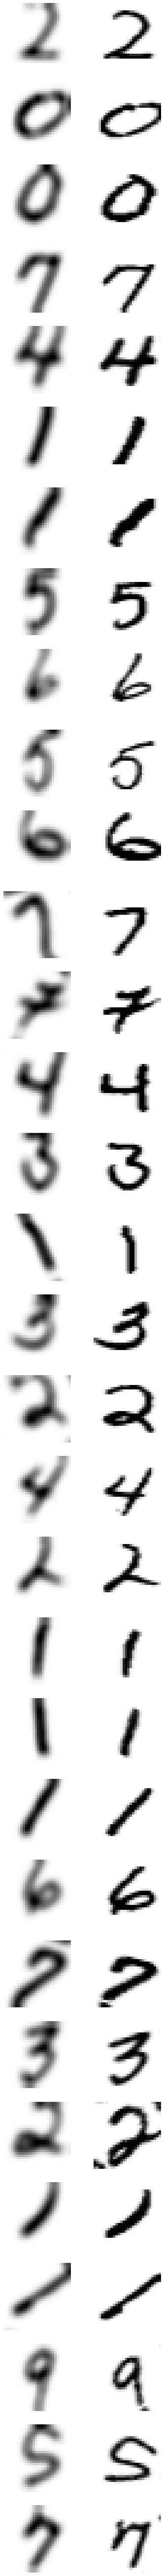

In [11]:
#A "reasonable" composite augmentation: initially copy pasted BT. We run this cell a few times to check it makes sense
#Also define encoder and model
fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=100,projection_size=100)# projection_size=1024)
#So aside from size, randomresizedcrop takes in two args: resize_scale and resize_ratio. So we want to put in 
#values for these which is tantamount to doing nothing
#So if we choose resize_scale=(1,1) then the images look the same.
#IMPORTANT: So this aug pipelines, insofar as I can tell at the moment, is tantamount to "do nothing"
aug_pipelines = get_barlow_twins_aug_pipelines(same_on_batch=False,size=28, rotate=True,flip_p=0,resize_scale=(0.7,1), jitter=False, bw=False,blur=True,blur_p=0.5,blur_s=8, stats=None, cuda=False)
learn = Learner(dls, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
dls.valid.bs = len(dls.valid_ds) #Set the validation dataloader batch size to be the length of the validation dataset

b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=32)

In [67]:
#Simple linear classifier
class LinearClassifier(nn.Module):
    
    def __init__(self,zdim):
        super().__init__()
        self.fc1 = nn.Linear(zdim,10) #As 10 classes for mnist
        
    def forward(self,x):
        x = cast(self.fc1(x),Tensor) #so we have to use cross entropy loss. cast is because using old version fastai 
        return x

In [68]:
learn.fit(1)
print('done')

epoch,train_loss,valid_loss,time


KeyboardInterrupt: 

In [73]:
#Train Classifier on encoder(mnist)

zdim=1024 #see above
head = LinearClassifier(zdim=zdim)
optimizer = torch.optim.Adam(head.parameters())
criterion = nn.CrossEntropyLoss()
EPOCHS=100
for epoch in range(EPOCHS):
    #break 
    b = dls.train.one_batch() #Seems need dls[0] or dls.train for training ... dls[1] is validation see here https://docs.fast.ai/data.core.html#DataLoaders.__getitem__
    x,y = b[0],b[1]

    loss = criterion(head(fastai_encoder(x)),y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss)
    
    if epoch>90:
        print(loss)
        

TensorCategory(2.3619, grad_fn=<AliasBackward0>)
TensorCategory(2.1774, grad_fn=<AliasBackward0>)
TensorCategory(2.0685, grad_fn=<AliasBackward0>)
TensorCategory(1.9830, grad_fn=<AliasBackward0>)


KeyboardInterrupt: 

In [108]:
#Test result of above cell on the validation set - assumes that batch size of valid-dataloader is = number of valid samples                                        
b = dls.valid.one_batch()
x,y = b[0],b[1]
ypred = head(fastai_encoder(x))
correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
print(correct.mean().item())



0.9756795167922974


In [75]:
#Just train a linear classifier (no encoder)
#Basically cell above but remove encoder and some re-shaping

zdim=28*28 #see above
head = LinearClassifier(zdim=zdim)
optimizer = torch.optim.Adam(head.parameters())
criterion = nn.CrossEntropyLoss()

EPOCHS=100
for epoch in range(EPOCHS):
    #break
    b = dls.train.one_batch() #see here https://docs.fast.ai/data.core.html#DataLoaders.__getitem__
    x,y = b[0],b[1]

    x=x.view(bs,zdim)
    x=cast(x, Tensor) #Have to do this when using old version of fastai for some reason...

    out = head(x)
    loss = criterion(out,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss)
    
    if epoch>90:
        print(loss)


TensorCategory(2.3457, grad_fn=<AliasBackward0>)
TensorCategory(2.2964, grad_fn=<AliasBackward0>)
TensorCategory(2.2385, grad_fn=<AliasBackward0>)
TensorCategory(2.1930, grad_fn=<AliasBackward0>)
TensorCategory(2.1532, grad_fn=<AliasBackward0>)
TensorCategory(2.1011, grad_fn=<AliasBackward0>)
TensorCategory(2.0655, grad_fn=<AliasBackward0>)
TensorCategory(2.0111, grad_fn=<AliasBackward0>)
TensorCategory(1.9650, grad_fn=<AliasBackward0>)
TensorCategory(1.9102, grad_fn=<AliasBackward0>)
TensorCategory(1.9128, grad_fn=<AliasBackward0>)
TensorCategory(1.8624, grad_fn=<AliasBackward0>)
TensorCategory(1.8390, grad_fn=<AliasBackward0>)
TensorCategory(1.8179, grad_fn=<AliasBackward0>)
TensorCategory(1.7613, grad_fn=<AliasBackward0>)
TensorCategory(1.6904, grad_fn=<AliasBackward0>)
TensorCategory(1.6816, grad_fn=<AliasBackward0>)
TensorCategory(1.6208, grad_fn=<AliasBackward0>)
TensorCategory(1.6097, grad_fn=<AliasBackward0>)
TensorCategory(1.5825, grad_fn=<AliasBackward0>)
TensorCategory(1.568

In [77]:
#Test result of above cell, (i.e. just a linear classifier), on the validation set - assumes that batch size of valid-dataloader is = number of valid samples                                        
b = dls.valid.one_batch()
x,y = b[0],b[1]
x = x.view(-1,zdim)
ypred = head(x)

correct = (torch.argmax(ypred,dim=1) == y).type(torch.FloatTensor)
print(correct.mean().item())

0.8671875
